# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA

# Load Data

In [2]:
# Load the data
file_path = "fic_epita_kantar_codes.csv"
data_codes = pd.read_csv(file_path, sep=';')

In [3]:
# Select relevant columns
columns_of_interest = [
    "A11", "A12", "A13", "A14", "A4", "A5", "A5bis",
    "A8_1_slice", "A8_2_slice", "A8_3_slice", "A8_4_slice",
    "B1_1_slice", "B1_2_slice", "B2_1_slice", "B2_2_slice",
    "B3", "B4", "B6",
    "C1_1_slice", "C1_2_slice", "C1_3_slice", "C1_4_slice",
    "C1_5_slice", "C1_6_slice", "C1_7_slice", "C1_8_slice", "C1_9_slice"
]
subset_data = data_codes[columns_of_interest]

In [4]:
# Check for missing values
missing_values = subset_data.isnull().sum()
print("Missing Values:\n", missing_values)

# Data type analysis
data_types = subset_data.dtypes
print("\nData Types:\n", data_types)

# Summary statistics
summary_stats = subset_data.describe()
print("\nSummary Statistics:\n", summary_stats)

# Check for outliers
outliers = subset_data.apply(zscore).abs() > 3
print("\nOutliers:\n", outliers)

Missing Values:
 A11              0
A12              0
A13              0
A14              0
A4               0
A5            1443
A5bis         3557
A8_1_slice       0
A8_2_slice       0
A8_3_slice       0
A8_4_slice       0
B1_1_slice       0
B1_2_slice       0
B2_1_slice       0
B2_2_slice       0
B3               0
B4               0
B6               0
C1_1_slice       0
C1_2_slice       0
C1_3_slice       0
C1_4_slice       0
C1_5_slice       0
C1_6_slice       0
C1_7_slice       0
C1_8_slice       0
C1_9_slice       0
dtype: int64

Data Types:
 A11             int64
A12             int64
A13             int64
A14             int64
A4              int64
A5            float64
A5bis         float64
A8_1_slice      int64
A8_2_slice      int64
A8_3_slice      int64
A8_4_slice      int64
B1_1_slice      int64
B1_2_slice      int64
B2_1_slice      int64
B2_2_slice      int64
B3              int64
B4              int64
B6              int64
C1_1_slice      int64
C1_2_slice      int64
C1_

In [5]:
# Handle NaN values in columns A5 and A5bis
subset_data['A5'].fillna(subset_data['A5'].mean(), inplace=True)
subset_data['A5bis'].fillna(subset_data['A5bis'].mean(), inplace=True)

/tmp/ipykernel_21221/3626455305.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  subset_data['A5'].fillna(subset_data['A5'].mean(), inplace=True)
/tmp/ipykernel_21221/3626455305.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['A5'].fillna(subset_data['A5'].mean(), inplace=True)
/tmp/ipykernel_21221/3626455305.py:3: FutureWar

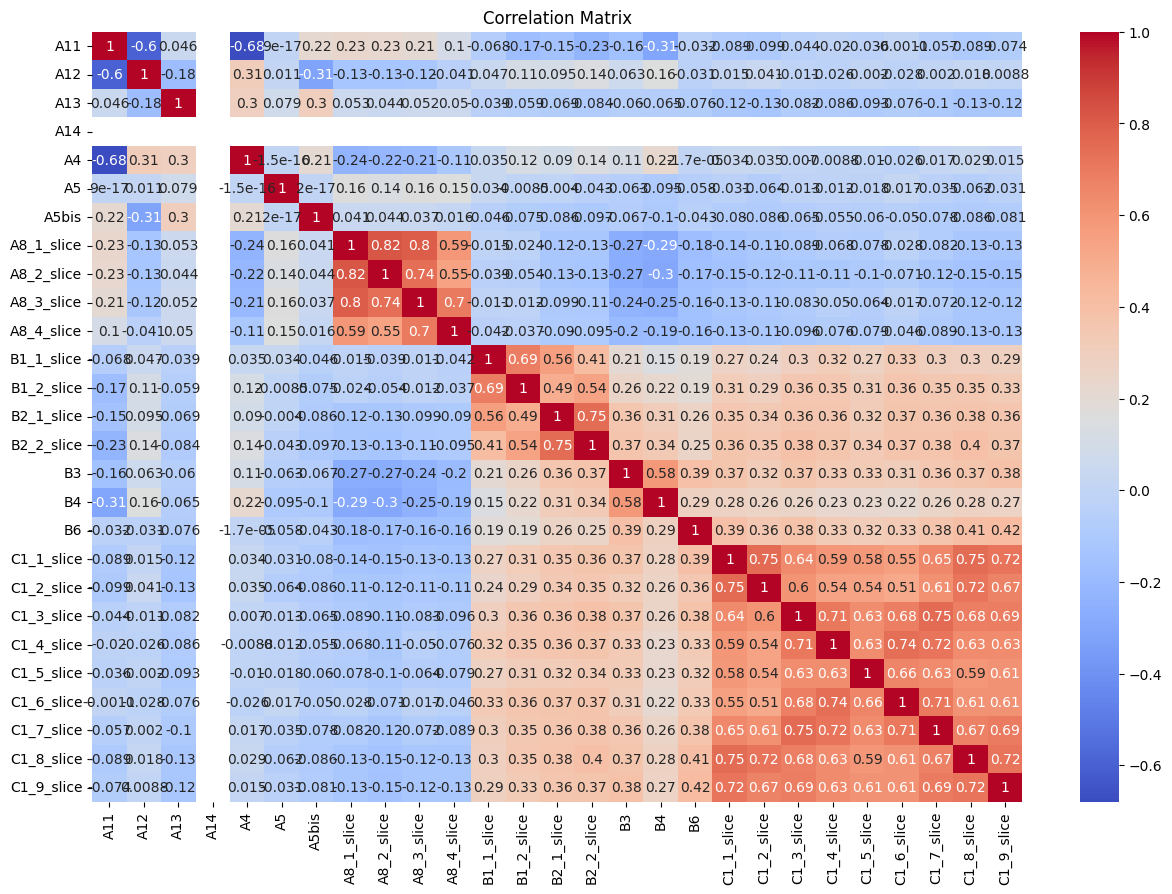

In [6]:
# Correlation heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(subset_data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [7]:
# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(subset_data)

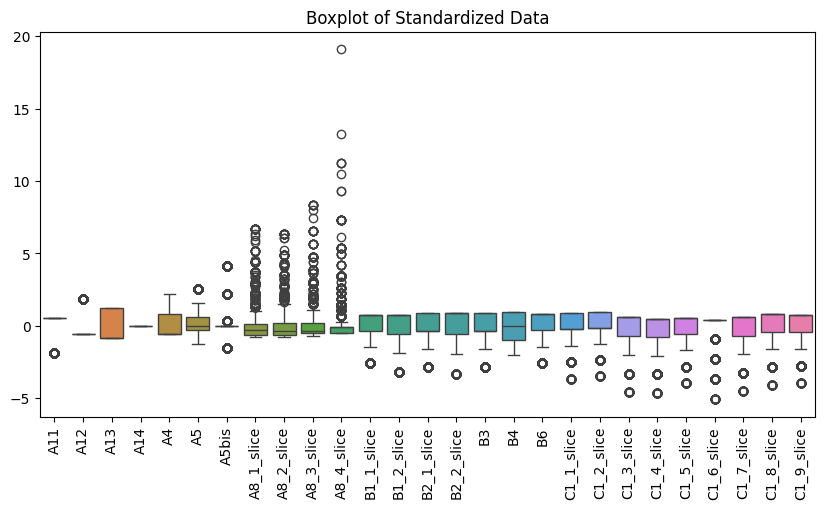

In [8]:
# Check if clustering is appropriate (variance and distribution)
plt.figure(figsize=(10, 5))
sns.boxplot(data=pd.DataFrame(scaled_data, columns=columns_of_interest))
plt.xticks(rotation=90)
plt.title("Boxplot of Standardized Data")
plt.show()

# Clustering

In [9]:
# Function to evaluate clustering
def evaluate_clustering(labels, data):
    if len(set(labels)) > 1:  # At least 2 clusters
        silhouette = silhouette_score(data, labels)
        davies_bouldin = davies_bouldin_score(data, labels)
        calinski_harabasz = calinski_harabasz_score(data, labels)
    else:
        silhouette, davies_bouldin, calinski_harabasz = None, None, None
    return silhouette, davies_bouldin, calinski_harabasz

results = {}

## Kmeans

In [10]:
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

def grid_search_kmeans(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        kmeans = KMeans(**params, random_state=42)
        kmeans_labels = kmeans.fit_predict(data)
        score = evaluate_clustering(kmeans_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for KMeans
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'init': ['k-means++', 'random'],
        'max_iter': [100, 300],
        'n_init': [10, 20]
    }
    
    pca_results[n_components] = grid_search_kmeans(reduced_data, param_grid)

results['K-Means'] = pca_results

## Hierarchical Clustering

In [11]:
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA

def grid_search_agglo(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        agglo = AgglomerativeClustering(**params)
        agglo_labels = agglo.fit_predict(data)
        score = evaluate_clustering(agglo_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for Agglomerative Clustering
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'linkage': ['ward', 'complete', 'average', 'single']
    }

    pca_results[n_components] = grid_search_agglo(reduced_data, param_grid)

results['Agglomerative'] = pca_results

## DBSCAN

In [12]:
from sklearn.model_selection import ParameterGrid

def grid_search_dbscan(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        dbscan = DBSCAN(**params)
        dbscan_labels = dbscan.fit_predict(data)
        score = evaluate_clustering(dbscan_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for Agglomerative Clustering
    param_grid = {
        'eps': [0.5, 1.0, 1.5, 2.0],
        'min_samples': [3, 5, 10, 15],
    }

    pca_results[n_components] = grid_search_dbscan(reduced_data, param_grid)

results['DBSCAN'] = pca_results

## Gaussian Mixture Model

In [13]:
from sklearn.model_selection import ParameterGrid

def grid_search_gmm(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        gmm = GaussianMixture(**params)
        gmm_labels = gmm.fit_predict(data)
        score = evaluate_clustering(gmm_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for Agglomerative Clustering
    param_grid = {
        'n_components': [3, 4, 5, 6, 7, 8, 9],
        'covariance_type': ['full', 'tied', 'diag', 'spherical'],
        'random_state': [42]
    }

    pca_results[n_components] = grid_search_gmm(reduced_data, param_grid)

results['GMM'] = pca_results

## Spectral Clustering

In [14]:
from sklearn.model_selection import ParameterGrid

def grid_search_spectral(data, param_grid):
    results = []
    for params in ParameterGrid(param_grid):
        spectral = SpectralClustering(**params)
        spectral_labels = spectral.fit_predict(data)
        score = evaluate_clustering(spectral_labels, data)
        results.append({'params': params, 'score': score})
    return results

# Try multiple values of PCA components
pca_results = {}
pca_components = [2, 3, 4, 5]  # List of PCA components to try

for n_components in pca_components:
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(scaled_data)
    
    # Define the parameter grid for Agglomerative Clustering
    param_grid = {
        'n_clusters': [3, 4, 5, 6, 7, 8, 9],
        'affinity': ['nearest_neighbors'],
        'random_state': [42]
    }

    pca_results[n_components] = grid_search_spectral(reduced_data, param_grid)

results['Spectral'] = pca_results

/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/floflo/Documents/epita/epita-ml-scia/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:

In [15]:
print(results)

{'K-Means': {2: [{'params': {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 3, 'n_init': 10}, 'score': (0.4024973580346682, 0.9384735512109831, 3911.7411719820284)}, {'params': {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 3, 'n_init': 20}, 'score': (0.4024973580346682, 0.9384735512109831, 3911.7411719820284)}, {'params': {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 4, 'n_init': 10}, 'score': (0.43696184323503295, 0.800807992091704, 4382.46484845105)}, {'params': {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 4, 'n_init': 20}, 'score': (0.43670553196911205, 0.8015655276876479, 4382.643219886097)}, {'params': {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 5, 'n_init': 10}, 'score': (0.36501089678069776, 0.8390424953834879, 4390.695531815)}, {'params': {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 5, 'n_init': 20}, 'score': (0.3650631940423554, 0.8385143445254073, 4390.769580451708)}, {'params': {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 6

## Results

In [16]:
# Display best score and hyperparameters for each method
best_hyperparameters = {}
for method, pca_comps in results.items():
    for pca in pca_comps:
        best_score = max(pca_comps[pca], key=lambda x: x['score'][0])  # Get the score with the highest first value
        if method not in best_hyperparameters:
            best_hyperparameters[method] = {'pca': pca, 'params': best_score['params'], 'score': best_score['score']}
        else:
            current_best_score = best_hyperparameters[method]['score']
            if best_score['score'] > current_best_score:
                best_hyperparameters[method] = {'pca': pca, 'params': best_score['params'], 'score': best_score['score']}

print("Best Hyperparameters:")
for method, params in best_hyperparameters.items():
    print(f"Method: {method}, PCA Components: {params['pca']}, Parameters: {params['params']}, Score: {params['score']}")


Best Hyperparameters:
Method: K-Means, PCA Components: 2, Parameters: {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 4, 'n_init': 10}, Score: (0.43696184323503295, 0.800807992091704, 4382.46484845105)
Method: Agglomerative, PCA Components: 2, Parameters: {'linkage': 'single', 'n_clusters': 3}, Score: (0.7144848175386341, 0.16920588504384718, 24.292275620344395)
Method: DBSCAN, PCA Components: 2, Parameters: {'eps': 2.0, 'min_samples': 3}, Score: (0.7214246011996667, 0.6788983701172336, 76.81002251018943)
Method: GMM, PCA Components: 2, Parameters: {'covariance_type': 'tied', 'n_components': 4, 'random_state': 42}, Score: (0.4375197819795308, 0.7369848464880445, 3188.3251681475836)
Method: Spectral, PCA Components: 2, Parameters: {'affinity': 'nearest_neighbors', 'n_clusters': 7, 'random_state': 42}, Score: (0.2025093367159689, 0.9011720995719121, 1702.3151644956567)


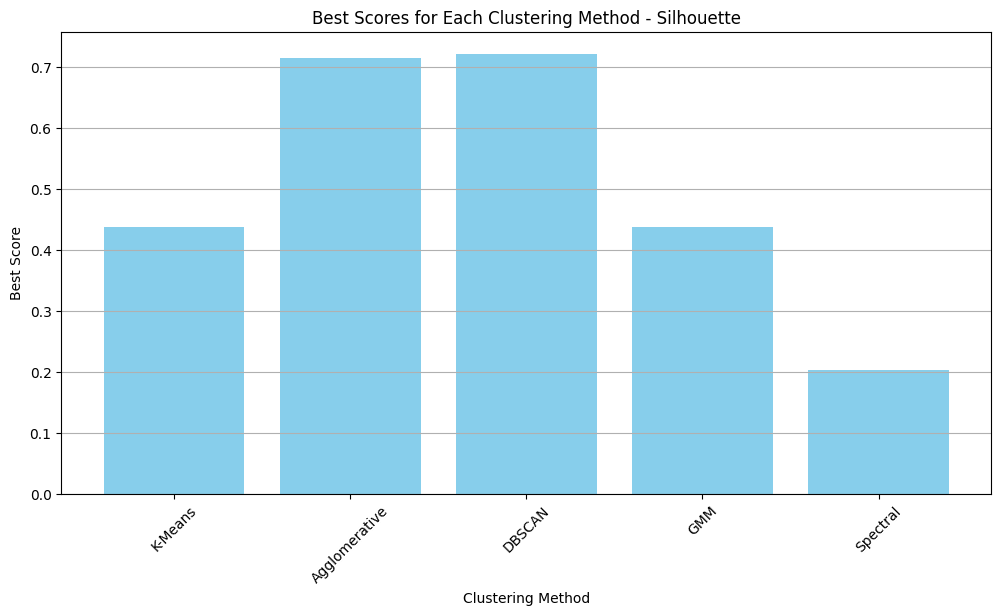

In [17]:
import matplotlib.pyplot as plt

# Data to plot
methods = list(best_hyperparameters.keys())
pca_components = [best_hyperparameters[method]['pca'] for method in methods]
scores = [best_hyperparameters[method]['score'][0] for method in methods]  # Using the first score for plotting

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(methods, scores, color='skyblue')
plt.title('Best Scores for Each Clustering Method - Silhouette')
plt.xlabel('Clustering Method')
plt.ylabel('Best Score')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()


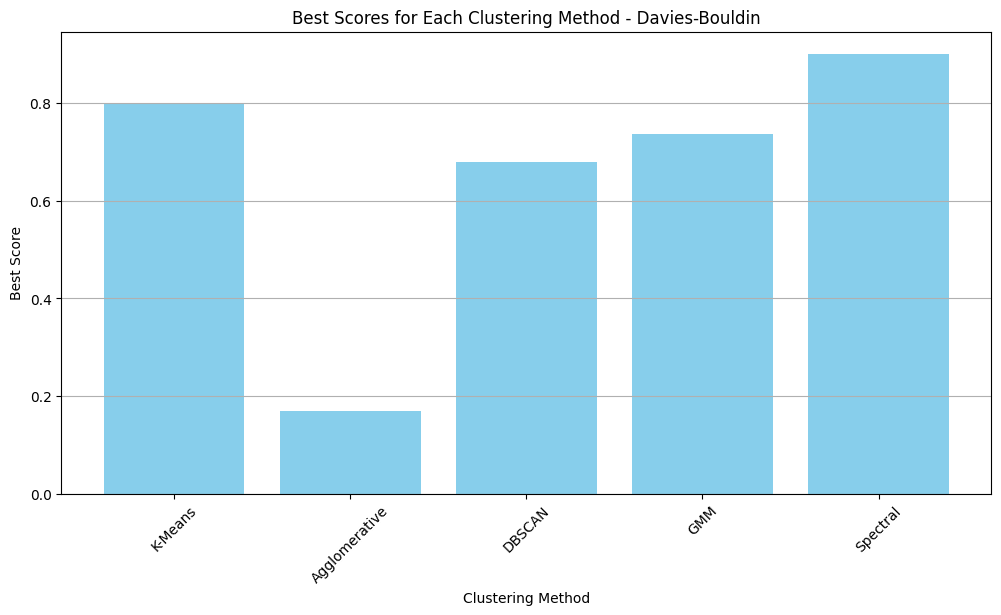

In [18]:
import matplotlib.pyplot as plt

# Data to plot
methods = list(best_hyperparameters.keys())
pca_components = [best_hyperparameters[method]['pca'] for method in methods]
scores = [best_hyperparameters[method]['score'][1] for method in methods]  # Using the first score for plotting

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(methods, scores, color='skyblue')
plt.title('Best Scores for Each Clustering Method - Davies-Bouldin')
plt.xlabel('Clustering Method')
plt.ylabel('Best Score')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()


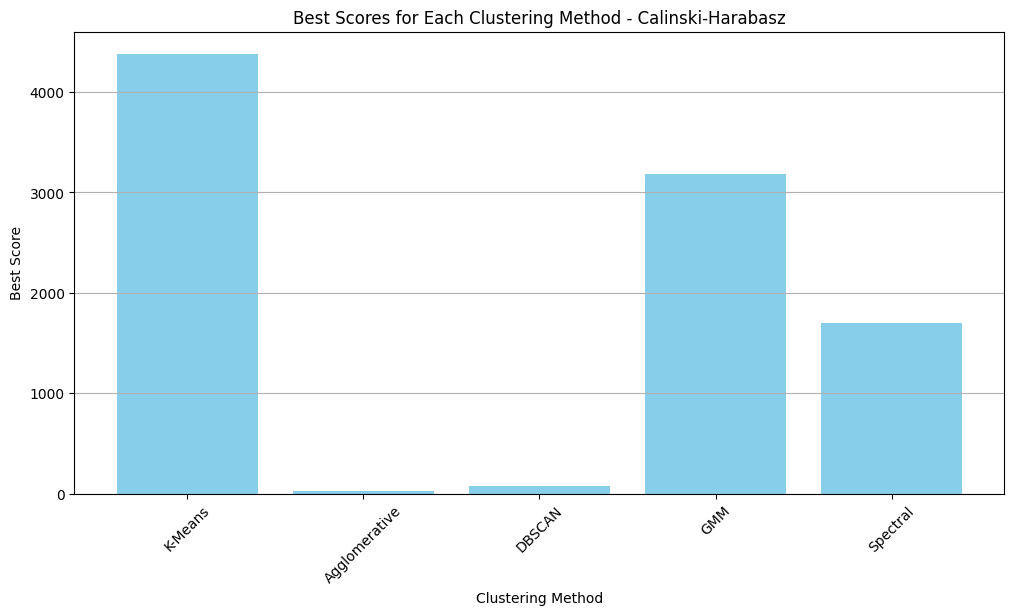

In [19]:
import matplotlib.pyplot as plt

# Data to plot
methods = list(best_hyperparameters.keys())
pca_components = [best_hyperparameters[method]['pca'] for method in methods]
scores = [best_hyperparameters[method]['score'][2] for method in methods]  # Using the first score for plotting

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(methods, scores, color='skyblue')
plt.title('Best Scores for Each Clustering Method - Calinski-Harabasz')
plt.xlabel('Clustering Method')
plt.ylabel('Best Score')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.show()


In [20]:
# Best clustering method: K-Means
best_method = "K-Means"
best_pca_components = 2
best_parameters = {'init': 'k-means++', 'max_iter': 100, 'n_clusters': 4, 'n_init': 10}
best_score = (0.43696184323503295, 0.800807992091704, 4382.46484845105)

# Apply K-Means with the best parameters
kmeans = KMeans(init=best_parameters['init'], max_iter=best_parameters['max_iter'], 
                n_clusters=best_parameters['n_clusters'], n_init=best_parameters['n_init'], random_state=42)
labels = kmeans.fit_predict(reduced_data)

# Calculate intra-cluster variances
intra_variances = []
n_clusters = best_parameters['n_clusters']  # Use the number of clusters from parameters
for k in range(n_clusters):
    cluster_data = reduced_data[labels == k]
    intra_variance = np.var(cluster_data, axis=0).mean()  # Mean variance of features
    intra_variances.append(intra_variance)

# Intra-group variance
variance_intra = np.mean(intra_variances)

# Calculate cluster centers
centers = kmeans.cluster_centers_

# Inter-group variance
mean_center = np.mean(centers, axis=0)
variance_inter = np.var(centers, axis=0).mean()  # Mean variance of centers

# Calculate the ratio
ratio = variance_inter / variance_intra

print(f"Variance Intra-Groupes: {variance_intra}")
print(f"Variance Inter-Groupes: {variance_inter}")
print(f"Ratio: {ratio}")


Variance Intra-Groupes: 2.1261409538972154
Variance Inter-Groupes: 3.32245739214457
Ratio: 1.562670332865047


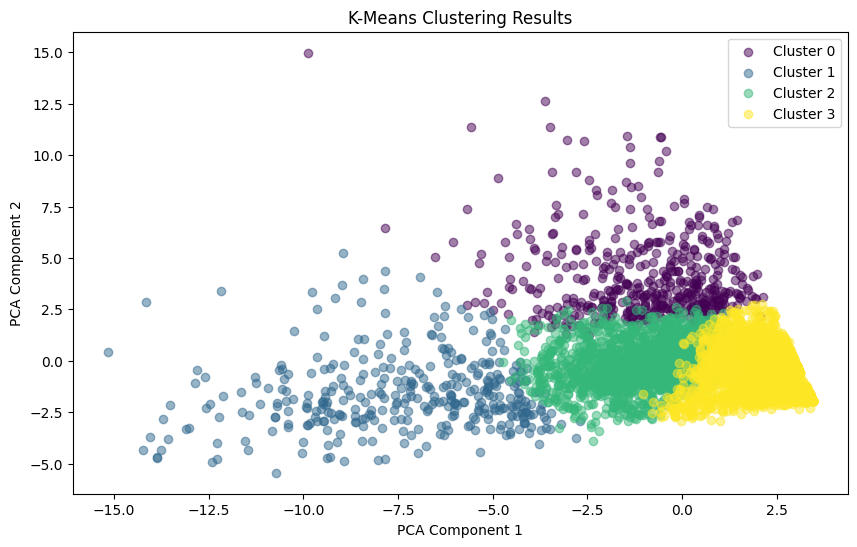

In [21]:
import matplotlib.pyplot as plt

# Plot the reduced data with cluster labels
plt.figure(figsize=(10, 6))
unique_labels = set(labels)
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))  # Updated to use viridis directly

for i, label in enumerate(unique_labels):
    if label == -1:  # Noise points
        color = 'k'  # Black for noise
    else:
        color = colors[i]  # Use the index to get the color
    plt.scatter(reduced_data[labels == label, 0], reduced_data[labels == label, 1], 
                color=color, label=f'Cluster {label}' if label != -1 else 'Noise', alpha=0.5)

plt.title('K-Means Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()


# Descriptif

In [23]:
# Assuming 'data' is your DataFrame and 'labels' are the cluster labels
subset_data['Cluster'] = labels  # Convert labels to a list before adding to the DataFrame

# Group by cluster and calculate summary statistics
cluster_summary = subset_data.groupby('Cluster').agg(['mean', 'std', 'count'])

# Display the summary statistics for each cluster
print(cluster_summary)

# Calculate the importance of each feature for each cluster
importance_summary = {}

for label in unique_labels:
    if label != -1:  # Skip noise points
        cluster_data = subset_data[subset_data['Cluster'] == label]
        importance = cluster_data.drop(columns=['Cluster']).mean()  # Calculate mean for each feature
        importance_summary[label] = importance

# Convert the summary to a DataFrame for better visualization
importance_df = pd.DataFrame(importance_summary).T

# Create a summary of the most important features for each cluster
importance_summary_str = {}

for label in unique_labels:
    if label != -1:  # Skip noise points
        # Get the importance of features for the current cluster
        importance = importance_df.loc[label]
        # Sort features by importance
        sorted_importance = importance.sort_values(ascending=False)
        # Create a summary string for the top features
        summary = ', '.join([f'{feature} : {value:.1f}' for feature, value in sorted_importance.items()])
        importance_summary_str[label] = summary

# Display the importance summary for each cluster
print("Importance Summary for Each Cluster:")
for label in importance_summary_str.keys():
    # Get the top 5 features for the current cluster
    top_features = importance_df.loc[label].nlargest(5)
    # Check the most common value for these features in the cluster
    most_common_values = {feature: subset_data[subset_data['Cluster'] == label][feature].mode()[0] for feature in top_features.index}
    print(f'Cluster {label}: {top_features.index.tolist()} with most common values: {most_common_values}')


              A11                       A12                       A13  \
             mean       std count      mean       std count      mean   
Cluster                                                                 
0        0.976395  0.151979   466  0.107296  0.309822   466  0.450644   
1        0.763587  0.425457   368  0.277174  0.448212   368  0.546196   
2        0.921525  0.268994  1784  0.117713  0.322358  1784  0.446749   
3        0.641898  0.479543  2382  0.320319  0.466697  2382  0.337112   

                         A14  ... C1_6_slice C1_7_slice                  \
              std count mean  ...      count       mean       std count   
Cluster                       ...                                         
0        0.498093   466  0.0  ...        466   4.628755  0.643870   466   
1        0.498539   368  0.0  ...        368   2.644022  0.916644   368   
2        0.497296  1784  0.0  ...       1784   4.409753  0.636112  1784   
3        0.472823  2382  0.0  ...     

/tmp/ipykernel_21221/2211454646.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_data['Cluster'] = labels  # Convert labels to a list before adding to the DataFrame


#### **Cluster 0 :**
#### **Features principales**
- **A8_1_slice** (Temps passé à l’entretien au printemps) : *20 heures*
- **A8_2_slice** (Temps passé à l’entretien en été) : *20 heures*
- **A8_3_slice** (Temps passé à l’entretien en automne) : *10 heures*
- **A8_4_slice** (Temps passé à l’entretien en hiver) : *5 heures*
- **C1_6_slice** (Fréquence consultation : Profils Instagram sur le jardinage) : *Jamais* (5)

#### **Description**
Ce cluster regroupe des individus qui :  
- Consacrent un temps significatif à l’entretien de leurs espaces extérieurs, surtout au printemps et en été, mais beaucoup moins en automne et hiver.  
- Ne s’intéressent pas à des contenus numériques liés au jardinage sur Instagram ou n’en consultent jamais.  

---

#### **Cluster 1 :**
#### **Features principales**
- **A8_2_slice** (Temps passé à l’entretien en été) : *1 heure*
- **A8_1_slice** (Temps passé à l’entretien au printemps) : *1 heure*
- **A8_3_slice** (Temps passé à l’entretien en automne) : *1 heure*
- **C1_6_slice** (Fréquence consultation : Profils Instagram sur le jardinage) : *Au moins une fois par semaine* (2)
- **C1_3_slice** (Fréquence consultation : Blogs d’experts en aménagement) : *Une à trois fois par mois* (3)

#### **Description**
Ce cluster regroupe des individus qui :  
- Passent très peu de temps à l’entretien de leurs espaces extérieurs, quelle que soit la saison.  
- Consultent régulièrement des profils Instagram dédiés au jardinage.  
- Lisent des blogs d’experts en aménagement quelques fois par mois pour s’inspirer ou s’informer.  

---

#### **Cluster 2 :**
#### **Features principales**
- **A8_2_slice** (Temps passé à l’entretien en été) : *2 heures*
- **C1_6_slice** (Fréquence consultation : Profils Instagram sur le jardinage) : *Jamais* (5)
- **C1_4_slice** (Fréquence consultation : Pages/groupes Facebook sur le jardinage) : *Jamais* (5)
- **C1_3_slice** (Fréquence consultation : Blogs d’experts en aménagement) : *Jamais* (5)
- **C1_7_slice** (Fréquence consultation : Forums de discussion sur le jardinage) : *Jamais* (5)

#### **Description**
Ce cluster regroupe des individus qui :  
- Passent très peu de temps à entretenir leurs espaces extérieurs, même en été.  
- Ne consultent jamais de contenus numériques liés au jardinage ou à l’aménagement des espaces extérieurs (Instagram, Facebook, blogs, forums).  
- Manifestent peu d’intérêt pour les échanges ou discussions autour de l’entretien des espaces extérieurs.  

---

#### **Cluster 3 :**
#### **Features principales**
- **C1_6_slice** (Fréquence consultation : Profils Instagram sur le jardinage) : *Jamais* (5)
- **C1_4_slice** (Fréquence consultation : Pages/groupes Facebook sur le jardinage) : *Jamais* (5)
- **C1_3_slice** (Fréquence consultation : Blogs d’experts en aménagement) : *Jamais* (5)
- **C1_7_slice** (Fréquence consultation : Forums de discussion sur le jardinage) : *Jamais* (5)
- **C1_5_slice** (Fréquence consultation : Pages Pinterest sur le jardinage) : *Jamais* (5)

#### **Description**
Ce cluster regroupe des individus qui :  
- Ne consultent jamais de contenus numériques en rapport avec le jardinage, que ce soit sur Instagram, Facebook, Pinterest, des blogs ou des forums.  
- Peuvent être caractérisés par un désintérêt total pour les ressources numériques ou en ligne dédiées à l’aménagement ou à l’entretien des espaces extérieurs.  

# Conclusion
Dans le cadre de notre analyse de clustering, nous avons réalisé un benchmark en utilisant plusieurs métriques de performance : Silhouette, Davies-Bouldin et Calinski-Harabasz. Nous avons appliqué différentes méthodes de clustering, notamment KMeans, Agglomerative Clustering, DBSCAN, Gaussian Mixture Model et Spectral Clustering.  
Les résultats de cette évaluation ont montré que le Kmeans, encore une fois offrait les meilleures performances globales selon les métriques analysées (surtout pour 4  clusters). En conséquence, nous avons décidé de nous concentrer sur cette méthode. 
 
En termes de variance, nous avons obtenu les résultats suivants : 
- Variance Intra-Groupes: 2.126
- Variance Inter-Groupes: 3.322
- Ratio: 1.562
 
Ces résultats soulignent l'efficacité du KMeans dans notre analyse.